# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pickle


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## EDA Profile dataset

In [4]:
# remove persons who don't present an income in the account
profile = profile[~profile['income'].isna()]

In [5]:
profile

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0


In [6]:
profile['became_member_on'] = profile['became_member_on'].astype(str)
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.date(year=int(x[0:4]),
                                                                           month=int(x[4:6]),
                                                                           day=int(x[6:8])))

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [7]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [8]:
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [9]:
df_gender = pd.DataFrame(gender_counts)

In [10]:
df_gender = df_gender.rename(columns={'gender': 'value'})

In [11]:
df_gender['gender'] = df_gender.index
# df_gender = df_gender.reset_index(drop=True)

In [12]:
df_gender

,value,gender
M,57.227656,M
F,41.342327,F
O,1.430017,O


Text(0, 0.5, 'Count')

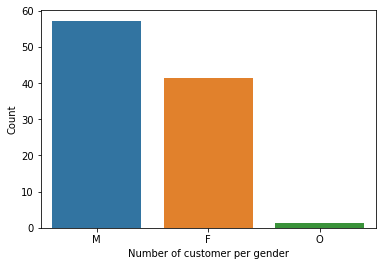

In [13]:
sns.barplot(x='gender', y='value', data=df_gender)
plt.xlabel('Number of customer per gender')
plt.ylabel('Count')

In [14]:
profile['gender_code'] = profile['gender'].apply(lambda gender: 0 if gender == 'M' else 1)

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
start_year = profile['became_member_on'].apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: became_member_on, dtype: float64

In [16]:
df_start_year = pd.DataFrame(start_year)
df_start_year['year'] = df_start_year.index

Text(0, 0.5, 'Count')

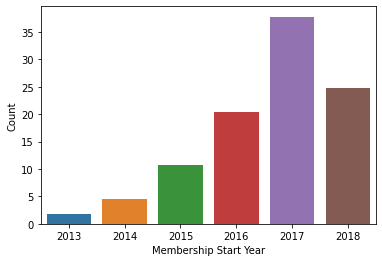

In [17]:
sns.barplot(x='year', y='became_member_on', data=df_start_year)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

In [18]:
age_df = profile[['age']]

In [19]:
def define_range(x):

    menor = x - x%10
    maior = menor + 10
    
    return str([menor, maior])

In [20]:
min_age = age_df.describe().loc['min', 'age']
max_age = age_df.describe().loc['max', 'age']

In [21]:
intervalo = [interval for interval in list(range(int(min_age), int(max_age), 10))]
age_df.loc[:, 'range']= age_df.apply(lambda x: define_range(x.loc['age']), axis=1, result_type='expand')
age_df.loc[:, 'count'] = 1
age_df = age_df.sort_values('age')
age_df.loc[:, 'count'] = age_df.groupby('range')['count'].transform('sum')
age_df = age_df.drop_duplicates(subset='range').reset_index(drop=True)

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
age_df

,age,range,count
0,18,"[10, 20]",205
1,20,"[20, 30]",1369
2,30,"[30, 40]",1526
3,40,"[40, 50]",2309
4,50,"[50, 60]",3541
5,60,"[60, 70]",2991
6,70,"[70, 80]",1782
7,80,"[80, 90]",831
8,90,"[90, 100]",254
9,100,"[100, 110]",17


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

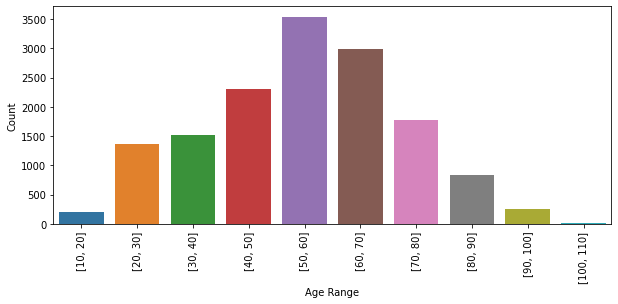

In [23]:
plt.figure(figsize=(10, 4))
sns.barplot(x='range', y='count', data=age_df)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

## EDA Portifolio dataset

In [24]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [25]:
df_dummy_offer_type = pd.get_dummies(portfolio['offer_type'])
portfolio = portfolio.join(df_dummy_offer_type)
portfolio = portfolio.drop('offer_type', axis=1)

In [28]:
def define_channels(channels):
    retorno = [0,0,0,0]
    if 'web' in channels:
        retorno[0] = 1

    if 'email' in channels:
        retorno[1] = 1

    if 'mobile' in channels:
        retorno[2] = 1
        
    if 'social' in channels:
        retorno[3] = 1
    
    return retorno

In [29]:
portfolio[['web', 'email', 'mobile', 'social']] = portfolio.apply(lambda linha: define_channels(linha['channels']), axis=1,result_type='expand')

In [30]:
portfolio = portfolio.drop('channels', axis=1)

In [31]:
portfolio = portfolio.rename(columns={'id': 'offer_id'})

In [32]:
portfolio.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'bogo', 'discount',
       'informational', 'web', 'email', 'mobile', 'social'],
      dtype='object')

In [34]:
portfolio[['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount',
       'informational', 'web', 'email', 'mobile', 'social']]

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,1,0


## EDA Transcript dataset

In [35]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [36]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

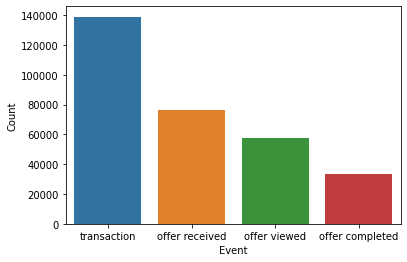

In [42]:
plt.figure()
sns.barplot(x='event', y='count', data=event_counts)
plt.xlabel('Event')
plt.ylabel('Count')
plt.xticks(rotation=0)

In [37]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


In [50]:
def define_transaction_offer(transcript):
    transcript['offer_id'] = transcript[['event', 'value']].apply(lambda dado: 
                                                              (dado['value']['offer id'] 
                                                              if dado['event'] == 'offer received'
                                                              else ''), axis=1)

    transcript['amount'] = transcript[['event', 'value']].apply(lambda dado: 
                                                              (dado['value']['amount'] 
                                                              if dado['event'] == 'transaction'
                                                              else ''), axis=1)
    
    
    offer_df = transcript.loc[transcript['event'] != 'transaction', ['event', 'offer_id', 'person', 'time']]
    
    transaction_df = transcript.loc[transcript['event'] == 'transaction', ['event', 'amount', 'person', 'time']]
    transaction_df['total_amount'] = transaction_df.groupby('person')['amount'].transform('sum')
    transaction_df = transaction_df[['person', 'total_amount', 'time']]
    
    return transaction_df, offer_df

In [182]:
transaction_df, offer_df = define_transaction_offer(transcript)

In [52]:
transaction_df.head()

,person,total_amount,time
12654,02c083884c7d45b39cc68e1314fec56c,29.89,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,320.48,0
12659,54890f68699049c2a04d415abc25e717,118.85,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,195.35,0
12671,fe97aa22dd3e48c8b143116a8403dd52,562.77,0


In [56]:
offer_df

,event,offer_id,person,time
0,offer received,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168
1,offer viewed,,0009655768c64bdeb2e877511632db8f,192
2,offer received,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336
3,offer viewed,,0009655768c64bdeb2e877511632db8f,372
4,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408
5,offer completed,,0009655768c64bdeb2e877511632db8f,414
6,offer viewed,,0009655768c64bdeb2e877511632db8f,456
7,offer received,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504
8,offer completed,,0009655768c64bdeb2e877511632db8f,528
9,offer viewed,,0009655768c64bdeb2e877511632db8f,540


In [54]:
offer_df = offer_df.drop_duplicates()

In [183]:
user_item_matrix.loc['0009655768c64bdeb2e877511632db8f']

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    NaN
2298d6c36e964ae4a3e7e9706d1fb8c2    NaN
2906b810c7d4411798c6938adc9daaa5    1.0
3f207df678b143eea3cee63160fa8bed    NaN
4d5c57ea9a6940dd891ad53e9dbe8da0    NaN
5a8bc65990b245e5a138643cd4eb9837    NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9    NaN
ae264e3637204a6fb9bb56bc8210ddfd    NaN
f19421c1d4aa40978ebb69ca19b0e20d    NaN
fafdcd668e3743c1bb461111dcafc2a4    NaN
Name: 0009655768c64bdeb2e877511632db8f, dtype: float64

In [184]:
offer_df = offer_df.sort_values(['person', 'time']).reset_index(drop=True)

In [185]:
len(offer_df)

167581

In [186]:
# val_linha_anterior = ''
# for i, linha in offer_df.iterrows():
#     if linha['offer_id'] == '':
#         offer_df.loc[i, 'offer_id'] = val_linha_anterior
        
#     val_atual = offer_df.loc[i, 'offer_id']
#     val_linha_anterior = val_atual

#offer_df.to_csv('salva_dados.csv')

In [193]:
offer_df = pd.read_csv('salva_dados.csv')

In [194]:
offer_df = offer_df.iloc[:, 1:]
offer_df.loc[:, 'count'] = 1

In [60]:
offer_df

,event,offer_id,person,time,count
0,offer received,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,1
1,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,192,1
2,offer received,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,1
3,offer viewed,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,372,1
4,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,1
5,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,414,1
6,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,456,1
7,offer received,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,1
8,offer completed,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,528,1
9,offer viewed,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,540,1


In [195]:
def clean_offer_data(offer_df):
    
    offer_df['count'] = offer_df.groupby(['person', 'offer_id', 'event'])['count'].transform('sum')
    
    offer_df = offer_df.drop_duplicates(subset=['event', 'offer_id', 'person', 'count'])
    
    offer_df['chave'] = offer_df[['offer_id', 'person']].apply(lambda x: '{}:{}'.format(x['person'], 
                                                                                        x['offer_id']), 
                                                           axis=1)
    
    offer_df = offer_df.reset_index(drop=True)
    
    offer_df = offer_df.pivot(index='chave', columns='event', values='count')
    offer_df['chave'] = offer_df.index
    
    offer_df[['person', 'offer_id']] = offer_df.apply(lambda x: x['chave'].split(':'), 
                                                      axis=1, result_type='expand')
    offer_df = (offer_df.fillna(0)
                        .reset_index(drop=True)
                        .drop(columns=['chave']))
    
    offer_df.loc[:, ['offer completed', 'offer received', 'offer viewed']] = offer_df.groupby(['person', 
                                                                                    'offer_id']).transform('sum')
    offer_df = offer_df.drop_duplicates(subset=['person', 'offer_id']).reset_index(drop=True)
    
    offer_df = offer_df.rename(columns={
        'offer completed': 'completed',
        'offer received': 'received',
        'offer viewed': 'viewed',
        'person': 'customer_id'
    })
    
    return offer_df
    

In [196]:
offer_clean_df = clean_offer_data(offer_df)

/Users/juliafreitas/anaconda3/envs/denox_python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [197]:
offer_clean_df[offer_clean_df['customer_id'] == '0009655768c64bdeb2e877511632db8f']

event,completed,received,viewed,customer_id,offer_id
0,1.0,1.0,0.0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5
1,0.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed
2,0.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837
3,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d
4,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4


In [217]:
offer_per_user_df = portfolio.merge(offer_clean_df, on='offer_id', how='outer')

In [239]:
offer_per_user_df[offer_per_user_df['customer_id'] == '0009655768c64bdeb2e877511632db8f']

,difficulty,duration,offer_id,reward,bogo,discount,informational,web,email,mobile,social,completed,received,viewed,customer_id
12704,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0,0.0,1.0,1.0,0009655768c64bdeb2e877511632db8f
38089,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f
44421,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,1,1,0.0,1.0,1.0,0009655768c64bdeb2e877511632db8f
50741,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f
57003,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,1,0,1.0,1.0,0.0,0009655768c64bdeb2e877511632db8f


In [221]:
offer_df = offer_per_user_df.drop('customer_id', axis=1)

In [222]:
offer_df[['completed', 'received', 'viewed',
         'web', 'email', 'mobile', 'social']] = (offer_df.groupby('offer_id')[['completed', 'received', 'viewed',
                                                                              'web', 'email', 'mobile', 'social']]
                                                         .transform('sum'))

In [223]:
offer_df = offer_df.drop_duplicates(subset='offer_id').reset_index(drop=True)

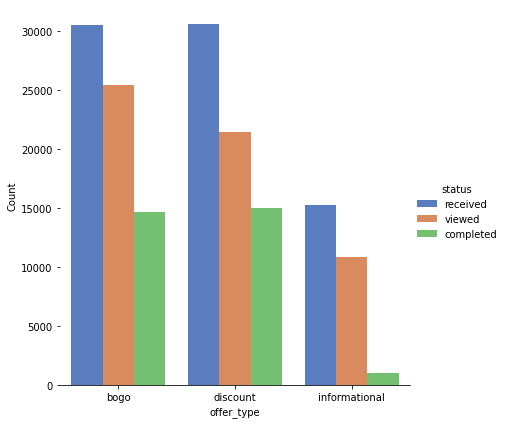

In [322]:
bogo = offer_df[offer_df['bogo'] == 1]
discount = offer_df[offer_df['discount'] == 1]
informational = offer_df[offer_df['informational'] == 1]


info_bogo = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [bogo['received'].sum(), bogo['viewed'].sum(), bogo['completed'].sum()],
    'offer_type': 'bogo'
})

info_discount = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [discount['received'].sum(), discount['viewed'].sum(), discount['completed'].sum()],
    'offer_type': 'discount'
})

info_informational = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [informational['received'].sum(), informational['viewed'].sum(), informational['completed'].sum()],
    'offer_type': 'informational'
})

df = pd.concat([info_bogo, info_discount])
df = pd.concat([df, info_informational])

g = sns.catplot(x="offer_type", y="valor", hue="status", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Count")

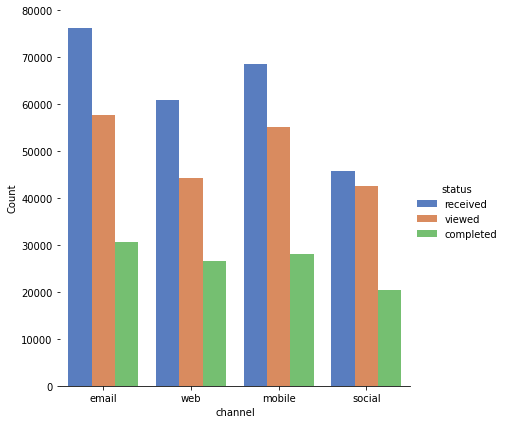

In [228]:
def retorna_valor(coluna_status, coluna_channel):
    
    return offer_df.loc[(offer_df[coluna_channel] >= 1)
                           & (offer_df[coluna_status] >= 1), coluna_status].sum()
                          

info_email = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [retorna_valor('received', 'email'),
              retorna_valor('viewed', 'email'),
              retorna_valor('completed', 'email')
             ],
    'channel': 'email'
})

info_web = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [retorna_valor('received', 'web'),
              retorna_valor('viewed', 'web'),
              retorna_valor('completed', 'web')
             ],
    'channel': 'web'
})

info_mobile = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [retorna_valor('received', 'mobile'),
              retorna_valor('viewed', 'mobile'),
              retorna_valor('completed', 'mobile')
             ],
    'channel': 'mobile'
})   
                          
info_social = pd.DataFrame({
    'status': ['received', 'viewed', 'completed'],
    'valor': [retorna_valor('received', 'social'),
              retorna_valor('viewed', 'social'),
              retorna_valor('completed', 'social')
             ],
    'channel': 'social'
})                         
                          
df = pd.concat([info_email, info_web])
df = pd.concat([df, info_mobile])
df = pd.concat([df, info_social])                         

g = sns.catplot(x="channel", y="valor", hue="status", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Count")

In [229]:
'''
porcentage of completed for each channel
'''
result = []

for channel,sdf in df.groupby('channel'):
    valor = sdf.loc[sdf['status'] == 'completed', 'valor'].sum()*100/sdf.loc[sdf['status'] == 'received', 'valor'].sum()
    result.append({
        'channel': channel,
        'porcent_comp': valor
    })
    

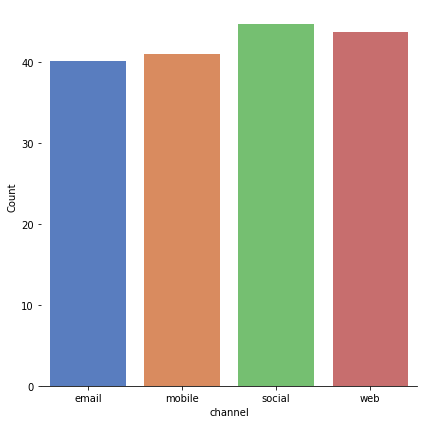

In [230]:
g = sns.catplot(x="channel", y="porcent_comp", data=pd.DataFrame(result),
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Count")

In [251]:
user_item_matrix = offer_per_user_df[['offer_id', 'completed', 'customer_id']]

In [252]:
user_item_matrix = user_item_matrix.pivot(index='customer_id', columns='offer_id', values='completed')

In [261]:
len_test = int(len(user_item_matrix)*0.70)

In [263]:
train_df = user_item_matrix[:len_test]

In [266]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [267]:
data_np = np.array(train_df)

# Fit FunkSVD
user_mat, offer_mat = FunkSVD(data_np, latent_features=12, learning_rate=0.005, iters=300)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.386959
2 		 0.350812
3 		 0.349463
4 		 0.348087
5 		 0.346697
6 		 0.345294
7 		 0.343874
8 		 0.342436
9 		 0.340976
10 		 0.339493
11 		 0.337983
12 		 0.336442
13 		 0.334866
14 		 0.333252
15 		 0.331593
16 		 0.329886
17 		 0.328124
18 		 0.326300
19 		 0.324409
20 		 0.322443
21 		 0.320393
22 		 0.318252
23 		 0.316011
24 		 0.313660
25 		 0.311190
26 		 0.308591
27 		 0.305853
28 		 0.302968
29 		 0.299925
30 		 0.296716
31 		 0.293333
32 		 0.289770
33 		 0.286022
34 		 0.282086
35 		 0.277962
36 		 0.273649
37 		 0.269155
38 		 0.264484
39 		 0.259649
40 		 0.254661
41 		 0.249536
42 		 0.244292
43 		 0.238950
44 		 0.233530
45 		 0.228055
46 		 0.222548
47 		 0.217030
48 		 0.211523
49 		 0.206047
50 		 0.200620
51 		 0.195259
52 		 0.189976
53 		 0.184784
54 		 0.179691
55 		 0.174704
56 		 0.169828
57 		 0.165066
58 		 0.160418
59 		 0.155885
60 		 0.151465
61 		 0.147157
62 		 0.142957
63 		 0.138862
64 		 0

In [268]:
def predict(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        user_ids = np.array(user_item_matrix.index)
        offer_ids = np.array(user_item_matrix.columns)
        

        # User row and offer Column
        user_row = np.where(user_ids == user_id)[0][0]
        offer_col = np.where(offer_ids == offer_id)[0][0]

                
        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        return pred
    
    except:    
        return None

In [277]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    
                    diff = test_df.loc[user_id, offer_id] - predict(user_mat, offer_mat, user_id, offer_id)

                    
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [278]:
validation(user_item_matrix, user_mat, offer_mat)

0.009393062976100963


In [269]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        #select the persons that completed offer_id
        persons = user_item_matrix.loc[user_item_matrix[offer_id] >= 1].index.tolist()
        
        # search how much this people spent
        total_amount = transaction_df.loc[transaction_df['person'].isin(persons), 'total_amount'].sum()
                          
        offer_gain.append([offer_id, total_amount])
        

    df_offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'amount'])
    df_offer_value = df_offer_value.sort_values(by='amount', ascending=False)
    
    return df_offer_value

In [285]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = []
    
    for offer_id in user_item_matrix.columns:
        pred_val = predict(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend.append({
                'offer_id': offer_id,
                'predicted_value': pred_val
            })
        else:
            break
    
    if pred_val == None:
        print("No records for this user. Here are top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(user_item_matrix)
        return top_offer
    else:
        print("Recommended offer for user ", user_id)
        return pd.DataFrame(recommend)
        

In [303]:
user_item_matrix

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,0.0,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,2.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,1.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0


In [304]:
user_id = 'ffff82501cea40309d5fdd7edcca4a07'

In [305]:
df_recomendado = recommend_offer(user_id, user_mat, offer_mat)

No records for this user. Here are top best sale offer recommendations for all users.


In [306]:
df_recomendado

,offer_id,amount
9,fafdcd668e3743c1bb461111dcafc2a4,7265910.37
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6828861.47
8,f19421c1d4aa40978ebb69ca19b0e20d,6149004.44
7,ae264e3637204a6fb9bb56bc8210ddfd,5957791.86
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5537506.07
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5409947.80
2,2906b810c7d4411798c6938adc9daaa5,5200716.70
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4036908.23
5,5a8bc65990b245e5a138643cd4eb9837,564760.79
3,3f207df678b143eea3cee63160fa8bed,512235.50


In [290]:
df_real = pd.DataFrame(user_item_matrix.loc[user_id])
df_real['offer_id'] = df_real.index
df_real.columns = ['real_value', 'offer_id']
df_real = df_real.reset_index(drop=True)
_df = df_real.merge(df_recomendado, on='offer_id')
colunas = ['offer_id', 'real_value', 'predicted_value']
_df = _df[colunas]

In [302]:
_df

,offer_id,real_value,predicted_value
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.074481
1,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,2.023258
2,2906b810c7d4411798c6938adc9daaa5,1.0,0.995619
3,3f207df678b143eea3cee63160fa8bed,0.0,-0.070390
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1.394164
5,5a8bc65990b245e5a138643cd4eb9837,0.0,-0.032476
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.677108
7,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0.861550
8,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.007846
9,fafdcd668e3743c1bb461111dcafc2a4,1.0,0.981697


In [315]:
offer_id = '2298d6c36e964ae4a3e7e9706d1fb8c2'
offers = ['2906b810c7d4411798c6938adc9daaa5', 'f19421c1d4aa40978ebb69ca19b0e20d',
         'fafdcd668e3743c1bb461111dcafc2a4']

In [318]:
offer_per_user_df[offer_per_user_df['offer_id'].isin(offers)]

,difficulty,duration,offer_id,reward,bogo,discount,informational,web,email,mobile,social,completed,received,viewed,customer_id
38089,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,0009655768c64bdeb2e877511632db8f
38090,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,2.0,1.0,0020c2b971eb4e9188eac86d93036a77
38091,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,0.0,2.0,2.0,003d66b6608740288d6cc97a6903f4f0
38092,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,00426fe3ffde4c6b9cb9ad6d077a13ea
38093,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,004b041fbfe44859945daa2c7f79ee64
38094,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,2.0,2.0,2.0,004c5799adbf42868b9cff0396190900
38095,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,00840a2ca5d2408e982d56544dc14ffd
38096,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,0.0,1.0,1.0,0099bf30e4cb4265875266eb3eb25eab
38097,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,00b18b535d6d4f779dea4dc9ac451478
38098,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1,1.0,1.0,1.0,00b3400e4ff64ee68ce9ada1d0c222f0
